In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from matplotlib.ticker import FormatStrFormatter
from src.utils import set_seed
import os
import warnings
warnings.filterwarnings("ignore")

wdir = os.path.abspath(os.path.dirname(__name__))
img_fold = '../figs/'
style='seaborn-v0_8-whitegrid'
# plt.style.use('ggplot')
# style = "ggplot"
white_back=False
# general settings
plt.style.use(style)
plt.rc('font', size=20)
plt.rc('legend', fontsize=20)
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('axes', edgecolor='k')
plt.rc('xtick.major', width=2)
plt.rc('xtick.major', size=12)
plt.rc('ytick.major', width=2)
plt.rc('ytick.major', size=12)
if style=='fivethirtyeight' and white_back==True:
    style+="WHITE"
    plt.rcParams['savefig.facecolor']='white'
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.grid'] = False

markers_dict = {
        'CC':"s",
     'RS': "o",
                "ASM":"d",
 'DT': "X",
 'LCE': "^",
 'OVA': "H",
 'SP': "D"}

palette = {q:sns.color_palette('colorblind')[i] for i,q in enumerate((markers_dict.keys()))}
seed = 42
set_seed(seed)
# file results
filename = "../results/all_results.csv"
if not os.path.exists(filename):
    raise FileNotFoundError("No results found. Run train.py and test.py first.")
else:
    df = pd.read_csv(filename)

Random seed 42 has been set.


In [2]:
palette

{'CC': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 'RS': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 'ASM': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 'DT': (0.8352941176470589, 0.3686274509803922, 0.0),
 'LCE': (0.8, 0.47058823529411764, 0.7372549019607844),
 'OVA': (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 'SP': (0.984313725490196, 0.6862745098039216, 0.8941176470588236)}

In [3]:
metric_dict = {"coef_rob": "$\\hat{\\tau}_{\mathtt{RDD}}$", "system_acc": "System Accuracy",
               "system_acc_v2": "System Accuracy", "ATT": "$\\hat{\\tau}_{\mathtt{ATD}}$",
               "classifier_all_acc": "System Accuracy", "pv_rob": "Estimated $\\tau$",
               "acc_system": "System Accuracy"}

def plot_single_classifier(df, classifier, figsize=(20, 12), title="", img_title="", metric="coef_rob", ylim = None):
    db = df[df['method']==classifier].copy()
    fig, ax = plt.subplots(1,1,figsize=figsize)
    classifiers = db["method"].unique()
    if metric == "coef_rob":
        target_covs = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
        for c in classifiers:
            db_c = db[db["method"] == c].copy()
            (_, caps, _) = ax.errorbar(db_c["target_coverage"], db_c["coef_rob"], label=c, color=palette[c],yerr=(db_c["ci_rob_u"]-db_c["ci_rob_l"])/2, alpha=0.9, capsize=10,
                        elinewidth=4, marker=markers_dict[c], markersize=20, markeredgecolor = 'black',markeredgewidth = 0.5)
            for cap in caps:
                cap.set_markeredgewidth(8)
        if ylim is not None:
            ax.set_ylim(ylim)
        else:
            ax.set_ylim(-.75, .75)
        ax.hlines(y=0, linestyles='dashed', colors='black', xmin=0, xmax=1, linewidth=4, label="Null Effect")
    elif metric == "ATT":
        target_covs = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
        for c in classifiers:
            db_c = db[db["method"] == c].copy()
            db_c = db_c[db_c["target_coverage"].isin(target_covs)]
            (_, caps, _) = ax.errorbar(db_c["target_coverage"], db_c["ATT"], label=c, color=palette[c],yerr=(db_c["ci_u_ATT"]-db_c["ci_l_ATT"])/2, alpha=0.9, capsize=10,
                        elinewidth=4, marker=markers_dict[c], markersize=20, markeredgecolor = 'black',markeredgewidth = 0.5)
            for cap in caps:
                cap.set_markeredgewidth(8)
        if ylim is not None:
            ax.set_ylim(ylim)
        else:
            ax.set_ylim(-.20, .50)
        ax.set_xlim(-0.04, 1.04)
        ax.hlines(y=0, linestyles='dashed', colors='black', xmin=0, xmax=1, linewidth=4, label="Null Effect")
    elif metric == "system_acc":
        target_covs = db["target_coverage"].unique()
        for c in classifiers:
            db_c = db[db["method"] == c].copy()
            ax.plot(db_c["target_coverage"], db_c[metric], label=c, color=palette[c], alpha=0.9,
                     marker=markers_dict[c], markersize=20, markeredgecolor = 'black',markeredgewidth = 0.5)
        if ylim is not None:
            ax.set_ylim(ylim)
        else:
            ax.set_ylim(.67, 1.01)
        class_all_acc = db_c["classifier_all_acc"].max()
        human_all_acc = db_c["human_all_acc"].max()
        ax.plot([0], [human_all_acc], label="Only Human", color="black", marker="P", markersize=20, markeredgecolor = 'black',markeredgewidth = 0.5)
        ax.plot([1], [class_all_acc], label="Only ML", color="black", marker="X", markersize=20, markeredgecolor = 'black',markeredgewidth = 0.5)
    elif metric == "acc_system":
        target_covs = db["target_coverage"].unique()
        for c in classifiers:
            db_c = db[db["method"] == c].copy()
            ax.plot(db_c["target_coverage"], db_c[metric], label=c, color=palette[c], alpha=0.9,
                     marker=markers_dict[c], markersize=20, markeredgecolor = 'black',markeredgewidth = 0.5)
        if ylim is not None:
            ax.set_ylim(ylim)
        else:
            ax.set_ylim(.67, 1.01)
    elif metric == "system_acc_v2":
        target_covs = db["target_coverage"].unique()
        for c in classifiers:
            db_c = db[db["method"] == c].copy()
            class_all_acc = db_c["classifier_all_acc"].max()
            human_all_acc = db_c[
        "human_all_acc"].max()
            xs = sorted([0]+list(target_covs)+[1])
            ys = [human_all_acc]+list(db_c["system_acc"].values)+[class_all_acc]
            ax.plot(xs, ys, label=c, color=palette[c], alpha=0.9,
                     marker=markers_dict[c], markersize=20, markeredgecolor = 'black',markeredgewidth = 0.5)
        ax.set_ylim(.67, 1.01)
    if "acc" in metric:
        ax.set_xlim(-0.04, 1.04)
    elif metric == "coef_rob":
        ax.set_xlim(-0.04, 1.04)
    elif metric == "ATT":
        ax.set_xlim(-0.04, 1.04)
    else:
        ax.set_xlim(0, 1)
    dataset = db["data"].unique()[0]
    if (dataset in ["hatespeech", "cifar10h", "chestxray2"])&(metric in ["system_acc", "acc_system"]):
        ax.legend(loc="lower left", fontsize=24, markerscale=1, fancybox=True, shadow=False)
    else:
        ax.legend(loc="upper left", fontsize=24, markerscale=1, fancybox=True, shadow=False)
    ax.set_xlabel("Cutoff", fontdict={"fontsize": 28})
    ax.set_ylabel(metric_dict[metric], fontdict={"fontsize": 28})
    labels_y = [str("{:.2f}".format(x)).replace("0.",".") for x in ax.get_yticks()]
    labels_y = [x if i%2==0 else "" for i, x in enumerate(labels_y)]
    ax.set_yticklabels(labels_y, fontsize=24)
    # ax.set_yticklabels(["{:.2f}".format(x) for x in ax.get_yticks()], fontsize=24)
    xticks = list(target_covs)
    ax.set_xticks(xticks)
    labels_cov = [str("{:.2f}".format(x)).replace("0.",".") for x in target_covs]
    # print(labels_cov)
    xticks_lab = ["$\\bar{}_{}$".format("{k}","{"+x+"}") for x in labels_cov]
    xticks_lab = [tick if i%2==0 else "" for i, tick in enumerate(xticks_lab)]
    # print(xticks_lab)
    ax.set_xticklabels(xticks_lab, fontsize=24)

    # ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_title(title, fontsize=20)
    plt.savefig("{}/{}_{}_allcoeffs_{}_oneaxis.png".format(img_fold, img_title, classifier, metric), bbox_inches='tight', dpi=300)
    plt.close()



In [4]:
df.sort_values(by=["data", "method", "target_coverage"], inplace=True)

In [5]:
for data in ["synth"]:
    for classifier in ["RS", "SP", "CC", "DT", "OVA", "LCE", "ASM"]:
        plot_single_classifier(df[df["data"]==data], classifier, img_title=data, figsize=(8,6), metric="coef_rob")
        plot_single_classifier(df[df["data"]==data], classifier, img_title=data, figsize=(8,6), metric="ATT")
        plot_single_classifier(df[df["data"]==data], classifier, img_title=data, figsize=(8,6), metric="acc_system")



In [6]:
for data in ["galaxyzoo"]:
    for classifier in ["RS", "SP", "CC", "DT", "OVA", "LCE", "ASM"]:
        plot_single_classifier(df[df["data"]==data], classifier, img_title=data, figsize=(8,6), metric="coef_rob")
        plot_single_classifier(df[df["data"]==data], classifier, img_title=data, figsize=(8,6), metric="ATT")
        plot_single_classifier(df[df["data"]==data], classifier, img_title=data, figsize=(8,6), metric="acc_system")

In [7]:
for data in ["hatespeech"]:
    for classifier in ["RS", "SP", "CC", "DT", "OVA", "LCE", "ASM"]:
        plot_single_classifier(df[df["data"]==data], classifier, img_title=data, figsize=(8,6), metric="coef_rob")
        plot_single_classifier(df[df["data"]==data], classifier, img_title=data, figsize=(8,6), metric="ATT")
        plot_single_classifier(df[df["data"]==data], classifier, img_title=data, figsize=(8,6), metric="acc_system")

In [8]:
for data in ["xray-airspace"]:
    for classifier in ["RS", "SP", "CC", "DT", "OVA", "LCE", "ASM"]:
        plot_single_classifier(df[df["data"]==data], classifier, img_title=data, figsize=(8,6), metric="coef_rob")
        plot_single_classifier(df[df["data"]==data], classifier, img_title=data, figsize=(8,6), metric="ATT")
        plot_single_classifier(df[df["data"]==data], classifier, img_title=data, figsize=(8,6), metric="acc_system")

In [9]:
for data in [ "cifar10h"]:
    for classifier in ["RS", "SP", "CC", "DT", "OVA", "LCE", "ASM"]:
        plot_single_classifier(df[df["data"]==data], classifier, img_title=data, figsize=(8,6), metric="coef_rob")
        plot_single_classifier(df[df["data"]==data], classifier, img_title=data, figsize=(8,6), metric="ATT")
        plot_single_classifier(df[df["data"]==data], classifier, img_title=data, figsize=(8,6), metric="acc_system")

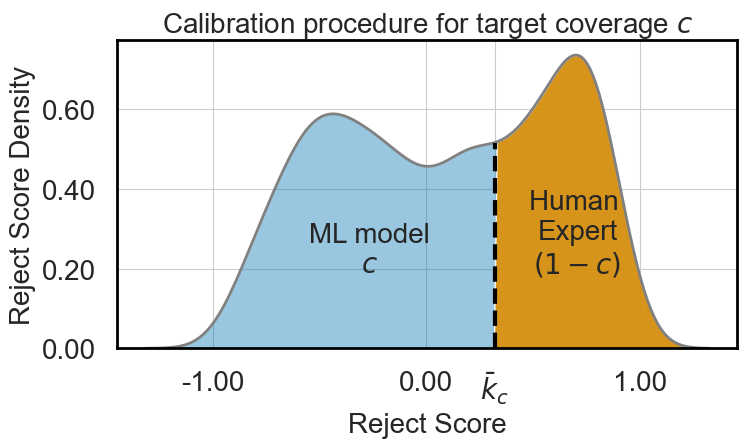

In [10]:
df_cal = pd.read_csv("../resultsRAW/synth/GCresultsRAW_cal_synth_RS_42_0.1_0.3_0.2_ep50.csv")
target_cov = .60
threshold = np.quantile(df_cal["rej_score"], target_cov)
colors = [sns.color_palette("colorblind")[0] if x < threshold else sns.color_palette("colorblind")[1] for x in df_cal["rej_score"]]
x = df_cal["rej_score"].values
fig, ax = plt.subplots(1,1, figsize=(8, 4))
sns.kdeplot(x, fill=False, color='grey', ax=ax)
kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
ax.set_title('Calibration procedure for target coverage ${c}$', fontsize=20)
ax.vlines(threshold, 0, np.interp(threshold, xs, ys), color='black', ls='--', lw=3)
ax.fill_between(xs, 0, ys, facecolor=sns.color_palette("colorblind")[0], alpha=0.4)
ax.fill_between(xs, 0, ys, where=(threshold <= xs), interpolate=True, facecolor=sns.color_palette("colorblind")[1], alpha=.9)
ax.set_xticks(sorted(list(np.linspace(-1,1, 3))+[threshold]))
ax.set_xticklabels(["{:.2f}".format(x) if x!=threshold else "$\\bar{k}_{{c}}$" for x in sorted(list(np.linspace(-1,1, 3))+[threshold])], fontsize=20)
fig.text(0.44, 0.3, 'ML model\n${c}$', ha='center', fontsize=20)
fig.text(0.7, 0.3, 'Human \nExpert\n$(1-{c})$', ha='center', fontsize=20)
# fig.text(0.5, -0.13, 'Reject Score', ha='center', fontsize=20)
ax.set_ylabel("Reject Score Density", fontsize=20)
ax.set_xlabel("Reject Score", fontsize=20)
ax.set_yticklabels(["{:.2f}".format(x) for x in ax.get_yticks()], fontsize=20)
# ax.set_ylim(ymin=0)
plt.savefig("{}/calibration_example.png".format(img_fold, target_cov), bbox_inches='tight', dpi=300)
plt.show()

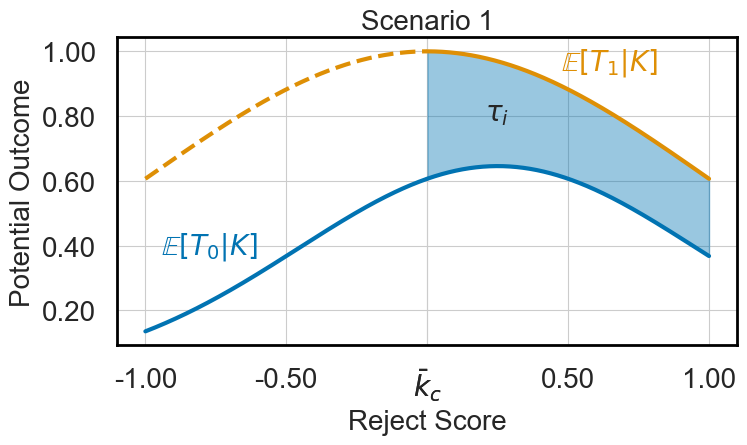

In [11]:
x_1 = np.linspace(-1, 1, 1000)
y_1 = np.exp(-x_1**2 + x_1*.5 -.5)
y_2 = np.exp(-x_1**2/2)

fig, ax = plt.subplots(1,1, figsize=(8, 4))
ax.plot(x_1[x_1>0], y_1[x_1>0], label="c=.60", color=sns.color_palette("colorblind")[0], lw=3)
ax.plot(x_1[x_1>0], y_2[x_1>0], label="c=.70", color=sns.color_palette("colorblind")[1], lw=3,)
ax.plot(x_1[x_1<=0], y_1[x_1<0], label="c=.60", color=sns.color_palette("colorblind")[0], lw=3)
ax.plot(x_1[x_1<=0], y_2[x_1<0], label="c=.70", color=sns.color_palette("colorblind")[1], lw=3, ls='--')
# // fill area between y_1[x_1>0] and y_2[x_1>0]
ax.fill_between(x_1[x_1>0], y_1[x_1>0], y_2[x_1>0], color=sns.color_palette("colorblind")[0], alpha=0.4)

# ax.plot(x_1, y_1-y_2, label="Difference", color='black')
# ax.vlines(0, np.interp(0, x_1, y_1), np.interp(0, x_1, y_2), color='black', ls='--', lw=3)
ax.set_title('Scenario 1', fontsize=20)
ax.set_xticks(sorted(list(np.linspace(-1,1, 5))+[0]))
ax.set_xticklabels(["{:.2f}".format(x) if x!=0 else "$\\bar{k}_{{c}}$" for x in sorted(list(np.linspace(-1,1, 5))+[0])], fontsize=20)
fig.text(0.24, 0.34, '$\mathbb{E}[T_0|K]$', ha='center', fontsize=20, color=sns.color_palette("colorblind")[0])
fig.text(0.74, 0.8, '$\mathbb{E}[T_1|K]$', ha='center', fontsize=20, color=sns.color_palette("colorblind")[1])
fig.text(0.60, 0.672, '$\\tau_{i}$', ha='center', fontsize=20)
ax.set_ylabel("Potential Outcome", fontsize=20)
ax.set_xlabel("Reject Score", fontsize=20)
ax.set_yticklabels(["{:.2f}".format(x) for x in ax.get_yticks()], fontsize=20)
# ax.set_ylim(ymin=0)
plt.savefig("{}/scenario1_example.png".format(img_fold, target_cov), bbox_inches='tight', dpi=300)

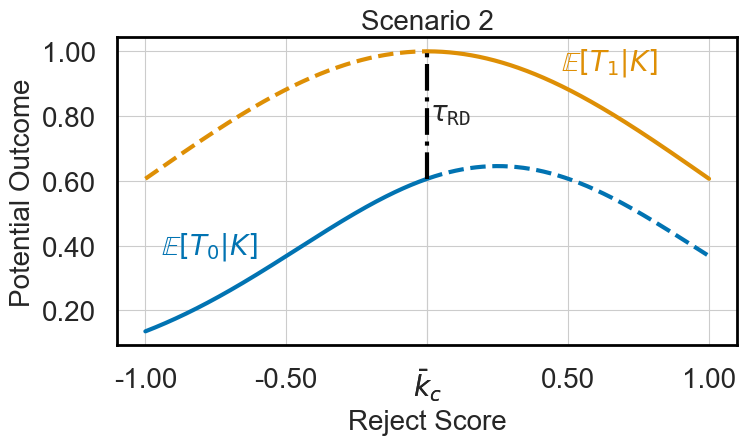

In [12]:
x_1 = np.linspace(-1, 1, 1000)
y_1 = np.exp(-x_1**2 + x_1*.5 -.5)
y_2 = np.exp(-x_1**2/2)

fig, ax = plt.subplots(1,1, figsize=(8, 4))
ax.plot(x_1[x_1>0], y_1[x_1>0], label="c=.60", color=sns.color_palette("colorblind")[0], lw=3, ls='--')
ax.plot(x_1[x_1>0], y_2[x_1>0], label="c=.70", color=sns.color_palette("colorblind")[1], lw=3,)
ax.plot(x_1[x_1<=0], y_1[x_1<0], label="c=.60", color=sns.color_palette("colorblind")[0], lw=3,)
ax.plot(x_1[x_1<=0], y_2[x_1<0], label="c=.70", color=sns.color_palette("colorblind")[1], lw=3, ls='--')

# ax.plot(x_1, y_1-y_2, label="Difference", color='black')
ax.vlines(0, np.interp(0, x_1, y_1), np.interp(0, x_1, y_2), color='black', ls='-.', lw=3)
ax.set_title('Scenario 2', fontsize=20)
ax.set_xticks(sorted(list(np.linspace(-1,1, 5))+[0]))
ax.set_xticklabels(["{:.2f}".format(x) if x!=0 else "$\\bar{k}_{{c}}$" for x in sorted(list(np.linspace(-1,1, 5))+[0])], fontsize=20)
fig.text(0.24, 0.34, '$\mathbb{E}[T_0|K]$', ha='center', fontsize=20, color=sns.color_palette("colorblind")[0])
fig.text(0.74, 0.8, '$\mathbb{E}[T_1|K]$', ha='center', fontsize=20, color=sns.color_palette("colorblind")[1])
fig.text(0.542, 0.672, '$\\tau_{\\mathtt{RD}}$', ha='center', fontsize=20)
ax.set_ylabel("Potential Outcome", fontsize=20)
ax.set_xlabel("Reject Score", fontsize=20)
ax.set_yticklabels(["{:.2f}".format(x) for x in ax.get_yticks()], fontsize=20)
# ax.set_ylim(ymin=0)
plt.savefig("{}/scenario2_example.png".format(img_fold, target_cov), bbox_inches='tight', dpi=300)

(0, 2)
['.00', '.10', '.20', '.30', '.40', '.50', '.60', '.70', '.80', '.90']
['$\\bar{k}_{.00}$', '', '$\\bar{k}_{.20}$', '', '$\\bar{k}_{.40}$', '', '$\\bar{k}_{.60}$', '', '$\\bar{k}_{.80}$', '']
(0, 0)
['.00', '.10', '.20', '.30', '.40', '.50', '.60', '.70', '.80', '.90']
['$\\bar{k}_{.00}$', '', '$\\bar{k}_{.20}$', '', '$\\bar{k}_{.40}$', '', '$\\bar{k}_{.60}$', '', '$\\bar{k}_{.80}$', '']
(0, 1)
['.00', '.10', '.20', '.30', '.40', '.50', '.60', '.70', '.80', '.90']
['$\\bar{k}_{.00}$', '', '$\\bar{k}_{.20}$', '', '$\\bar{k}_{.40}$', '', '$\\bar{k}_{.60}$', '', '$\\bar{k}_{.80}$', '']
(0, 3)
['.00', '.10', '.20', '.30', '.40', '.50', '.60', '.70', '.80', '.90']
['$\\bar{k}_{.00}$', '', '$\\bar{k}_{.20}$', '', '$\\bar{k}_{.40}$', '', '$\\bar{k}_{.60}$', '', '$\\bar{k}_{.80}$', '']
(1, 2)
['.00', '.10', '.20', '.30', '.40', '.50', '.60', '.70', '.80', '.90', '1.00']
['$\\bar{k}_{.00}$', '', '$\\bar{k}_{.20}$', '', '$\\bar{k}_{.40}$', '', '$\\bar{k}_{.60}$', '', '$\\bar{k}_{.80}$', '

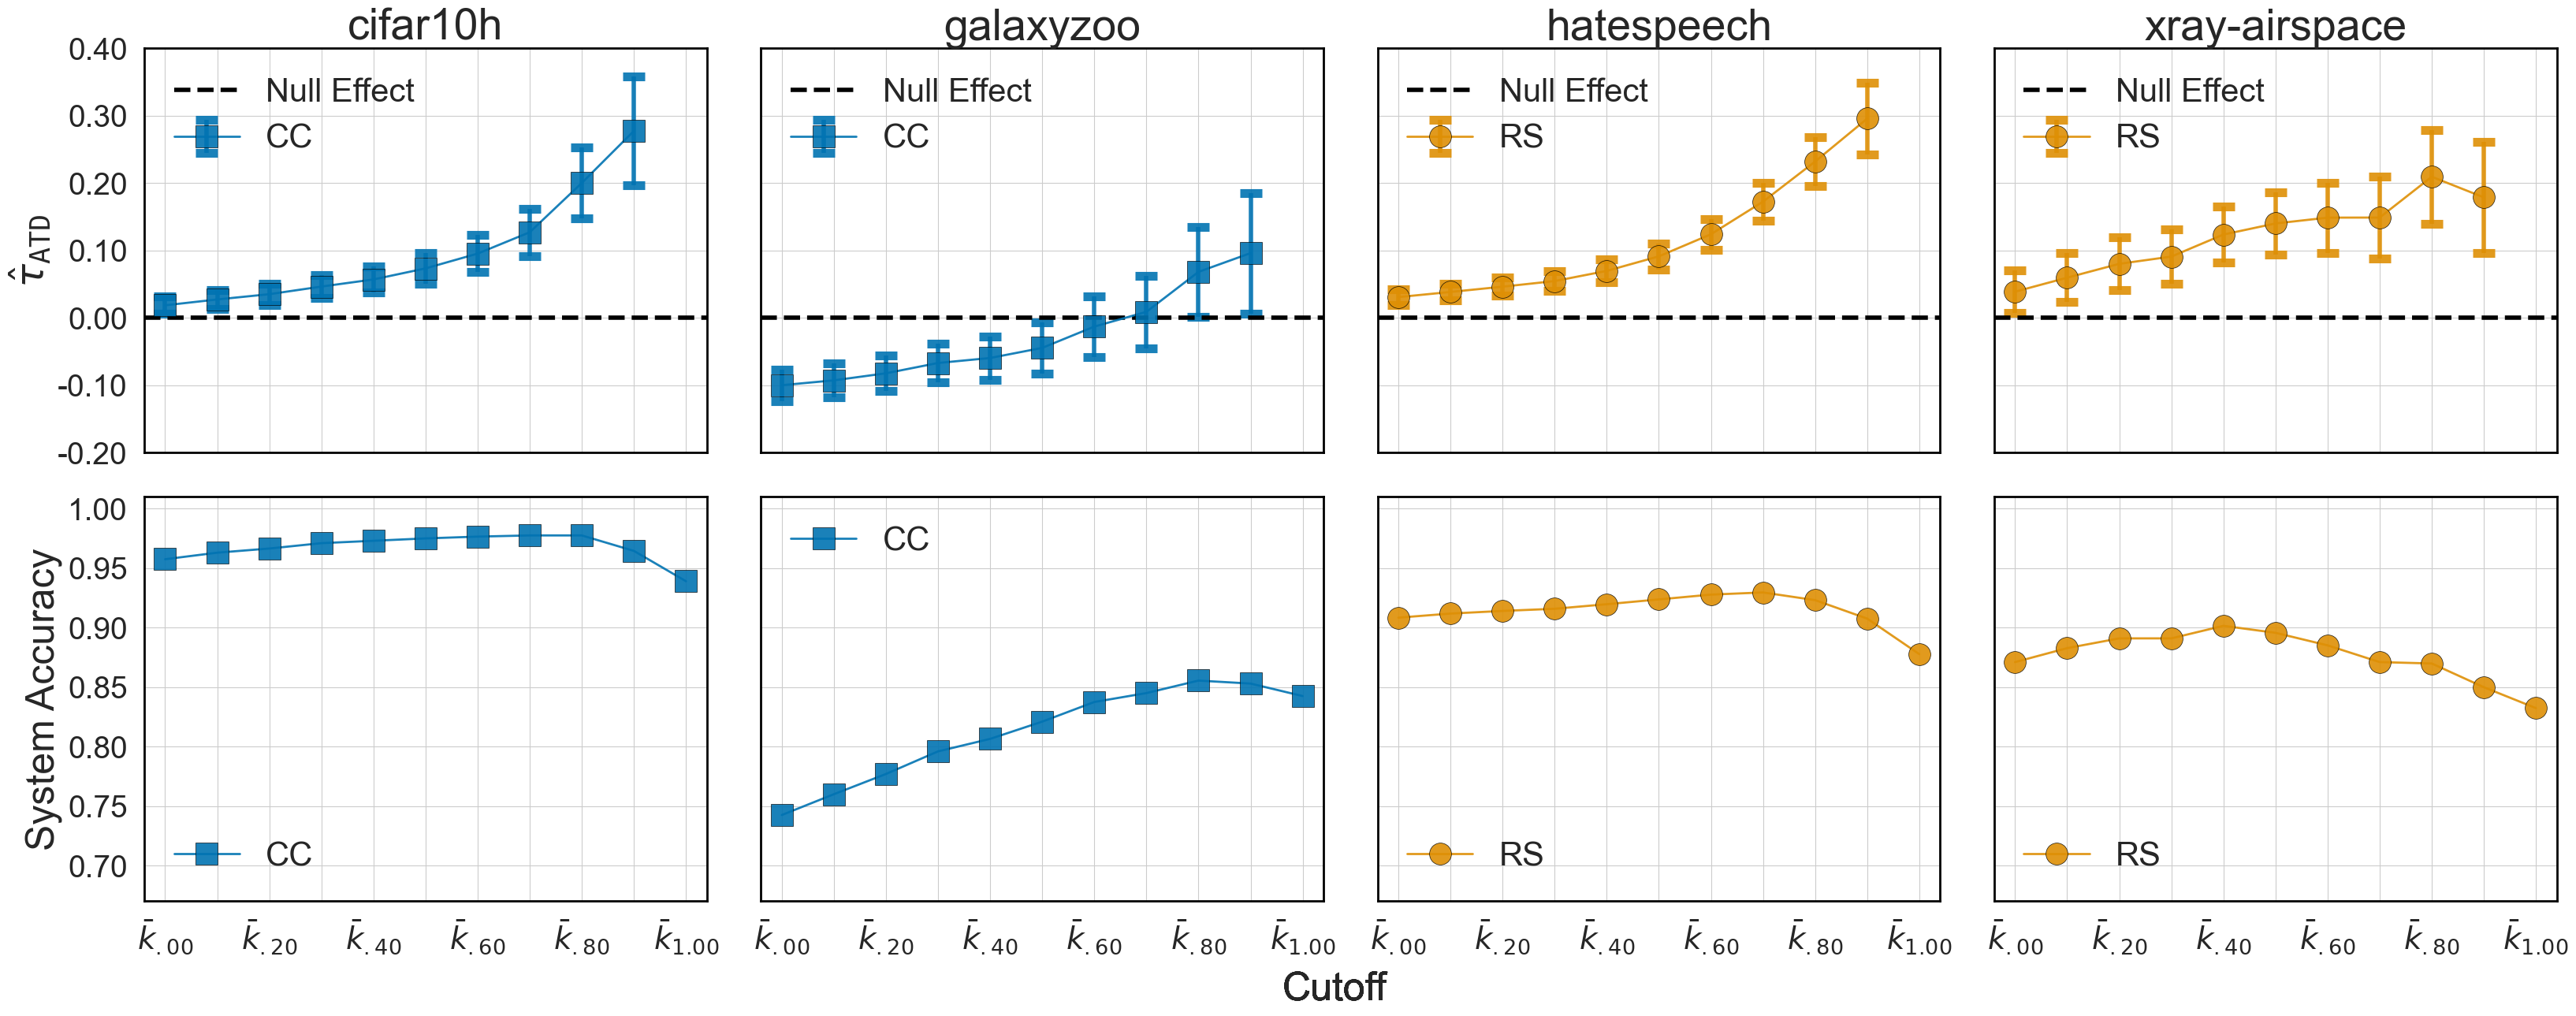

In [13]:
ax_dict = {
    "hatespeech": 2,
    "cifar10h": 0,
    "galaxyzoo": 1,
    "xray-airspace": 3
}


best_classifier = {
    "hatespeech": "RS",
    "cifar10h": "CC",
    "galaxyzoo": "CC",
    "xray-airspace": "RS"
}

def plot_all_real_best(df, datasets, figsize=(20, 12), title="", metric="coef_rob"):
    if metric == "all":
        fig, ax = plt.subplots(2,len(datasets),figsize=figsize, sharey="row", sharex=True)
        fig.tight_layout() #
    else:
        fig, ax = plt.subplots(1,len(datasets),figsize=figsize, sharey=True)
        fig.tight_layout() #
    df = df.copy()
    if metric == "all":
        metrics = ["ATT", "acc_system"]
        for metric in metrics:
            for data in datasets:
                classifier = best_classifier[data]
                db = df[(df["data"]==data) & (df['method']==classifier)].copy()
                # target_covs = db["target_coverage"].unique()
                if metric == "coef_rob":
                    pos = (0,ax_dict[data])
                    target_covs = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
                    db = db[db["target_coverage"].isin(target_covs)]
                elif metric == "system_acc":
                    pos = (1,ax_dict[data])
                elif metric == "ATT":
                    pos = (0,ax_dict[data])
                    target_covs = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
                    db = db[db["target_coverage"].isin(target_covs)]
                else:
                    pos = (1,ax_dict[data])
                print(pos)
                title = data
                classifiers = db["method"].unique()
                if metric == "coef_rob":
                    for c in classifiers:
                        db_c = db[db["method"] == c].copy()
                        (_, caps, _) = ax[pos].errorbar(db_c["target_coverage"], db_c["coef_rob"], label=c, color=palette[c],yerr=(db_c["ci_rob_u"]-db_c["ci_rob_l"])/2, alpha=0.9, capsize=10,
                                    elinewidth=4, marker=markers_dict[c], markersize=20, markeredgecolor = 'black',markeredgewidth = 0.5)
                        for cap in caps:
                            cap.set_markeredgewidth(8)
                    if pos == 0:
                        ax[pos].set_ylim(-.75, .75)
                    ax[pos].hlines(y=0, linestyles='dashed', colors='black', xmin=-0.04, xmax=1.04, linewidth=4)
                elif metric == "ATT":
                    for c in classifiers:
                        db_c = db[db["method"] == c].copy()
                        (_, caps, _) = ax[pos].errorbar(db_c["target_coverage"], db_c["ATT"], label=c, color=palette[c],yerr=(db_c["ci_u_ATT"]-db_c["ci_l_ATT"])/2, alpha=0.9, capsize=10,
                                    elinewidth=4, marker=markers_dict[c], markersize=20, markeredgecolor = 'black',markeredgewidth = 0.5)
                        for cap in caps:
                            cap.set_markeredgewidth(8)
                    if pos == (0,0):
                        ax[pos].set_ylim(-.20, .40)
                    ax[pos].hlines(y=0, linestyles='dashed', colors='black', xmin=-0.04, xmax=1.04, label="Null Effect", linewidth=4)
                elif metric == "acc_system":
                    for c in classifiers:
                        db_c = db[db["method"] == c].copy()
                        ax[pos].plot(db_c["target_coverage"], db_c[metric], label=c, color=palette[c], alpha=0.9,
                                 marker=markers_dict[c], markersize=20, markeredgecolor = 'black',markeredgewidth = 0.5)
                    ax[pos].set_ylim(.67, 1.01)
                if "acc_system" in metric:
                    ax[pos].set_xlim(-0.04, 1.04)
                else:
                    ax[pos].set_xlim(0, 1)
                dataset = db["data"].unique()[0]
                if (dataset in ["hatespeech", "cifar10h", "xray-airspace"])&("acc" in metric):
                    ax[pos].legend(loc="lower left", fontsize=30, markerscale=1, fancybox=True, shadow=False)
                else:
                    ax[pos].legend(loc="upper left", fontsize=30, markerscale=1, fancybox=True, shadow=False)
                if pos[1] == 0:
                    ax[pos].set_ylabel(metric_dict[metric], fontdict={"fontsize": 36})
                else:
                    ax[pos].set_ylabel("")
                # ax[pos].set_xlabel("Cutoff", fontdict={"fontsize": 20})
                if pos[0] == 0:
                    ax[pos].set_title(title, fontsize=40)
                ax[pos].set_xlabel("")
                fig.text(0.5, -0.04, "Cutoff", ha='center', fontsize=36)
                labels_y = [str("{:.2f}".format(x)).replace("0.",".") for x in ax[pos].get_yticks()]
                labels_y = [x if i%2==0 else "" for i, x in enumerate(labels_y)]
                ax[pos].set_yticklabels(labels_y, fontsize=28)
                target_covs = list(db["target_coverage"].unique())
                xticks = list(target_covs)
                ax[pos].set_xticks(xticks)
                labels_cov = [str("{:.2f}".format(x)).replace("0.",".") for x in target_covs]
                print(labels_cov)
                xticks_lab = ["$\\bar{}_{}$".format("{k}","{"+x+"}") for x in labels_cov]
                xticks_lab = [tick if i%2==0 else "" for i, tick in enumerate(xticks_lab)]
                print(xticks_lab)
                ax[pos].set_xticklabels(xticks_lab, fontsize=28)

        # ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
                ax[pos].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    else:
        for data in datasets:
                classifier = best_classifier[data]
                db = df[(df["data"]==data) & (df['method']==classifier)].copy()
                target_covs = db["target_coverage"].unique()
                pos = ax_dict[data]
                print(pos)
                title = data
                classifiers = db["method"].unique()
                if metric == "coef_rob":
                    for c in classifiers:
                        db_c = db[db["method"] == c].copy()
                        (_, caps, _) = ax[pos].errorbar(db_c["target_coverage"], db_c["coef_rob"], label=c, color=palette[c],yerr=(db_c["ci_rob_u"]-db_c["ci_rob_l"])/2, alpha=0.9, capsize=10,
                                    elinewidth=4, marker=markers_dict[c], markersize=20, markeredgecolor = 'black',markeredgewidth = 0.5)
                        for cap in caps:
                            cap.set_markeredgewidth(8)
                    if pos == 0:
                        ax[pos].set_ylim(-.75, .75)
                    ax[pos].hlines(y=0, linestyles='dashed', colors='black', xmin=0, xmax=1, linewidth=4)
                elif metric == "acc_system":
                    for c in classifiers:
                        db_c = db[db["method"] == c].copy()
                        ax[pos].plot(db_c["target_coverage"], db_c[metric], label=c, color=palette[c], alpha=0.9,
                                 marker=markers_dict[c], markersize=20, markeredgecolor = 'black',markeredgewidth = 0.5)
                    ax[pos].set_ylim(.67, 1.01)
                    class_all_acc = db_c["classifier_all_acc"].max()
                    human_all_acc = db_c["human_all_acc"].max()
                    # ax.hlines(y=db_c["classifier_all_acc"].max(), linestyles='dashed', colors='black', xmin=0, xmax=1, linewidth=4, label = "ML model accuracy")
                    # ax.hlines(y=db_c["human_all_acc"].max(), linestyles='dashed', colors='black', xmin=0, xmax=1, linewidth=4, label = "Human expert accuracy")
                    ax[pos].plot([0], [human_all_acc], label="Only Human", color="black", marker="P", markersize=20, markeredgecolor = 'black',markeredgewidth = 0.5)
                    ax[pos].plot([1], [class_all_acc], label="Only ML", color="black", marker="X", markersize=20, markeredgecolor = 'black',markeredgewidth = 0.5)
                elif metric == "ATT":
                    for c in classifiers:
                        db_c = db[db["method"] == c].copy()
                        (_, caps, _) = ax[pos].errorbar(db_c["target_coverage"], db_c["ATT"], label=c, color=palette[c],yerr=(db_c["ci_u_ATT"]-db_c["ci_l_ATT"])/2, alpha=0.9, capsize=10,
                                    elinewidth=4, marker=markers_dict[c], markersize=20, markeredgecolor = 'black',markeredgewidth = 0.5)
                        for cap in caps:
                            cap.set_markeredgewidth(8)
                    if pos == 0:
                        ax[pos].set_ylim(-.75, .75)
                    ax[pos].hlines(y=0, linestyles='dashed', colors='black', xmin=0, xmax=1, linewidth=4)
                if "acc_system" in metric:
                    ax[pos].set_xlim(-0.04, 1.04)
                else:
                    ax[pos].set_xlim(0, 1)
                dataset = db["data"].unique()[0]
                if (dataset in ["hatespeech", "cifar10h", "chestxray2"])&("acc" in metric):
                    ax[pos].legend(loc="lower left", fontsize=22, markerscale=1, fancybox=True, shadow=False)
                else:
                    ax[pos].legend(loc="upper left", fontsize=22, markerscale=1, fancybox=True, shadow=False)
                if pos == 0:
                    ax[pos].set_ylabel(metric_dict[metric], fontdict={"fontsize": 20})
                else:
                    ax[pos].set_ylabel("")
                # ax[pos].set_xlabel("Cutoff", fontdict={"fontsize": 20})
                ax[pos].set_title(title, fontsize=40)
                ax[pos].set_xlabel("")
                fig.text(0.5, -0.04, "Cutoff", ha='center', fontsize=20)
                ax[pos].set_yticklabels(["{:.2f}".format(x) for x in ax[pos].get_yticks()], fontsize=20)
                target_covs = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
                xticks = list(target_covs)
                ax[pos].set_xticks(xticks)
                labels_cov = [str("{:.2f}".format(x)).replace("0.",".") for x in target_covs]
                print(labels_cov)
                xticks_lab = ["$\\bar{}_{}$".format("{k}","{"+x+"}") for x in labels_cov]
                xticks_lab = [tick if i%2==0 else "" for i, tick in enumerate(xticks_lab)]
                print(xticks_lab)
                ax[pos].set_xticklabels(xticks_lab, fontsize=24)
    plt.savefig("{}/{}_{}_allcoeffs_{}_oneaxis.png".format(img_fold, title, "best", metric), bbox_inches='tight', dpi=300)



plot_all_real_best(df.fillna(0), ["hatespeech","cifar10h", "galaxyzoo", "xray-airspace"], figsize=(32, 12), metric="all", title="all_real")

In [14]:
df[(df["data"] == "cifar10h") & (df["method"] == "CC")]

,data,method,target_coverage,ATT,ci_l_ATT,ci_u_ATT,pv_rob_ATT,acc_hum,acc_ML,acc_system,...,N_h_l,N_h_r,c,p,q,coef_rob,se_rob,pv_rob,ci_rob_l,ci_rob_u
21,cifar10h,CC,0.0,0.018500,0.005481,0.031519,5.351282e-03,0.957500,0.000000,0.9575,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,cifar10h,CC,0.1,0.027180,0.012929,0.041431,1.853930e-04,0.958097,1.000000,0.9630,...,229.0,730.0,-0.073313,1.0,2.0,-0.017260,0.013146,0.189206,-0.043025,0.008506
12,cifar10h,CC,0.2,0.034987,0.019351,0.050623,1.156514e-05,0.957379,1.000000,0.9665,...,415.0,976.0,-0.058398,1.0,2.0,-0.045969,0.015797,0.003615,-0.076932,-0.015007
13,cifar10h,CC,0.3,0.046276,0.029196,0.063356,1.094053e-07,0.958785,0.998379,0.9710,...,253.0,306.0,-0.047036,1.0,2.0,-0.000092,0.009252,0.992079,-0.018226,0.018042
14,cifar10h,CC,0.4,0.056856,0.037720,0.075993,5.772685e-09,0.957358,0.996269,0.9730,...,415.0,507.0,-0.036750,1.0,2.0,-0.000851,0.027085,0.974943,-0.053935,0.052234
15,cifar10h,CC,0.5,0.073245,0.050600,0.095890,2.304741e-10,0.953204,0.996067,0.9750,...,585.0,560.0,-0.026650,1.0,2.0,-0.020012,0.019079,0.294240,-0.057407,0.017383
16,cifar10h,CC,0.6,0.095178,0.067686,0.122670,1.157559e-11,0.947970,0.995050,0.9765,...,639.0,389.0,-0.016667,1.0,2.0,0.015503,0.012906,0.229661,-0.009792,0.040798
17,cifar10h,CC,0.7,0.126853,0.091835,0.161872,1.248649e-12,0.935750,0.995693,0.9775,...,364.0,190.0,-0.009175,1.0,2.0,-0.000789,0.002458,0.748056,-0.005607,0.004028
18,cifar10h,CC,0.8,0.200000,0.147550,0.252450,7.803610e-14,0.906494,0.994427,0.9775,...,643.0,63.0,0.021714,1.0,2.0,0.100863,0.050337,0.045098,0.002203,0.199523
19,cifar10h,CC,0.9,0.277174,0.196410,0.357938,1.738834e-11,0.885870,0.972467,0.9645,...,98.0,72.0,0.213820,1.0,2.0,0.259805,0.114881,0.023727,0.034643,0.484966


In [15]:
df[(df["data"] == "xray-airspace") & (df["method"] == "RS")]

,data,method,target_coverage,ATT,ci_l_ATT,ci_u_ATT,pv_rob_ATT,acc_hum,acc_ML,acc_system,...,N_h_l,N_h_r,c,p,q,coef_rob,se_rob,pv_rob,ci_rob_l,ci_rob_u
164,xray-airspace,RS,0.0,0.038687,0.006669,0.070705,1.787614e-02,0.871043,0.000000,0.871043,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154,xray-airspace,RS,0.1,0.059474,0.023212,0.095737,1.306562e-03,0.864454,0.984615,0.882767,...,51.0,69.0,-0.142076,1.0,2.0,-0.311639,0.124340,0.012198,-0.555341,-0.067938
155,xray-airspace,RS,0.2,0.080000,0.040519,0.119481,7.144490e-05,0.864000,0.964912,0.890973,...,149.0,109.0,0.026509,1.0,2.0,-0.161408,0.110246,0.143177,-0.377487,0.054671
156,xray-airspace,RS,0.3,0.090744,0.049885,0.131603,1.343425e-05,0.871143,0.927152,0.890973,...,63.0,100.0,0.209074,1.0,2.0,-0.472839,0.180902,0.008954,-0.827400,-0.118278
157,xray-airspace,RS,0.4,0.123431,0.081990,0.164872,5.291471e-09,0.903766,0.898667,0.901524,...,60.0,293.0,0.349077,1.0,2.0,-0.068729,0.112808,0.542355,-0.289829,0.152371
158,xray-airspace,RS,0.5,0.139896,0.094236,0.185557,1.912824e-09,0.917098,0.877944,0.895662,...,146.0,338.0,0.385792,1.0,2.0,0.125274,0.081705,0.125213,-0.034864,0.285412
159,xray-airspace,RS,0.6,0.148515,0.096467,0.200563,2.236818e-08,0.920792,0.865455,0.885111,...,212.0,265.0,0.408059,1.0,2.0,0.155160,0.074385,0.036988,0.009367,0.300952
160,xray-airspace,RS,0.7,0.148649,0.088437,0.208860,1.306945e-06,0.914414,0.855784,0.871043,...,302.0,214.0,0.429875,1.0,2.0,0.072719,0.078074,0.351638,-0.080302,0.225741
161,xray-airspace,RS,0.8,0.209150,0.139345,0.278956,4.295512e-09,0.941176,0.854286,0.869871,...,344.0,145.0,0.452688,1.0,2.0,0.077495,0.079246,0.328120,-0.077824,0.232815
162,xray-airspace,RS,0.9,0.178571,0.095682,0.261461,2.417130e-05,0.940476,0.840052,0.849941,...,338.0,78.0,0.482494,1.0,2.0,0.166749,0.103218,0.106202,-0.035555,0.369053


In [16]:
df[(df["data"] == "galaxyzoo") & (df["method"] == "CC")]

,data,method,target_coverage,ATT,ci_l_ATT,ci_u_ATT,pv_rob_ATT,acc_hum,acc_ML,acc_system,...,N_h_l,N_h_r,c,p,q,coef_rob,se_rob,pv_rob,ci_rob_l,ci_rob_u
98,galaxyzoo,CC,0.0,-0.100000,-0.123202,-0.076798,2.980741e-17,0.742500,0.000000,0.7425,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,galaxyzoo,CC,0.1,-0.092801,-0.117505,-0.068096,1.805544e-13,0.744657,0.882883,0.7600,...,124.0,1303.0,-2.913755e-03,1.0,2.0,-0.149719,0.037823,7.544865e-05,-0.223851,-0.075587
89,galaxyzoo,CC,0.2,-0.082338,-0.108609,-0.056067,8.106672e-10,0.741672,0.914425,0.7770,...,312.0,1148.0,-2.868533e-04,1.0,2.0,-0.152858,0.021033,3.660334e-13,-0.194081,-0.111634
90,galaxyzoo,CC,0.3,-0.067051,-0.095989,-0.038113,5.589529e-06,0.734679,0.934747,0.7960,...,524.0,972.0,-3.036261e-05,1.0,2.0,-0.164969,0.017888,2.902699e-20,-0.200028,-0.129909
91,galaxyzoo,CC,0.4,-0.059652,-0.091817,-0.027487,2.780842e-04,0.717481,0.941992,0.8065,...,708.0,800.0,-4.768372e-07,1.0,2.0,-0.180120,0.019551,3.175472e-20,-0.218439,-0.141801
92,galaxyzoo,CC,0.5,-0.044652,-0.082827,-0.006477,2.187532e-02,0.689512,0.943105,0.8210,...,954.0,568.0,2.264977e-05,1.0,2.0,-0.205526,0.026355,6.267389e-15,-0.257180,-0.153872
93,galaxyzoo,CC,0.6,-0.013089,-0.058014,0.031836,5.679753e-01,0.670157,0.940939,0.8375,...,1156.0,378.0,8.614063e-04,1.0,2.0,-0.227815,0.036863,6.411305e-10,-0.300066,-0.155564
94,galaxyzoo,CC,0.7,0.008803,-0.045077,0.062683,7.488058e-01,0.653169,0.921089,0.8450,...,1347.0,201.0,6.993026e-03,1.0,2.0,-0.177648,0.070405,1.162810e-02,-0.315639,-0.039657
95,galaxyzoo,CC,0.8,0.068063,0.000944,0.135181,4.686230e-02,0.667539,0.899876,0.8555,...,1525.0,113.0,4.065734e-02,1.0,2.0,0.152667,0.114956,1.841634e-01,-0.072643,0.377978
96,galaxyzoo,CC,0.9,0.095890,0.006441,0.185340,3.563329e-02,0.662100,0.876474,0.8530,...,1729.0,158.0,1.538646e-01,1.0,2.0,0.210857,0.123404,8.751251e-02,-0.031011,0.452724


In [17]:
df[(df["data"] == "hatespeech") & (df["method"] == "RS")]

,data,method,target_coverage,ATT,ci_l_ATT,ci_u_ATT,pv_rob_ATT,acc_hum,acc_ML,acc_system,...,N_h_l,N_h_r,c,p,q,coef_rob,se_rob,pv_rob,ci_rob_l,ci_rob_u
241,hatespeech,RS,0.0,0.030670,0.019403,0.041937,9.541159e-08,0.908394,0.000000,0.908394,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231,hatespeech,RS,0.1,0.038296,0.025933,0.050659,1.270112e-09,0.903467,0.979742,0.911824,...,543.0,890.0,-0.968745,1.0,2.0,-0.019699,0.022372,0.378579,-0.063546,0.024149
232,hatespeech,RS,0.2,0.046118,0.032457,0.059780,3.675954e-11,0.898283,0.972460,0.914044,...,940.0,778.0,-0.943529,1.0,2.0,-0.000355,0.025438,0.988860,-0.050213,0.049503
233,hatespeech,RS,0.3,0.054451,0.039436,0.069467,1.181698e-12,0.892538,0.970370,0.915860,...,700.0,537.0,-0.919697,1.0,2.0,0.004560,0.035079,0.896576,-0.064194,0.073314
234,hatespeech,RS,0.4,0.069542,0.052631,0.086453,7.632307e-16,0.885991,0.970992,0.919693,...,1070.0,668.0,-0.888014,1.0,2.0,-0.074682,0.030547,0.014493,-0.134553,-0.014811
235,hatespeech,RS,0.5,0.091091,0.071883,0.110299,1.474697e-20,0.881742,0.966572,0.923729,...,477.0,351.0,-0.845093,1.0,2.0,-0.092220,0.041708,0.027032,-0.173967,-0.010473
236,hatespeech,RS,0.6,0.123876,0.100962,0.146790,3.119360e-26,0.872128,0.965471,0.927764,...,729.0,440.0,-0.779967,1.0,2.0,-0.067556,0.043415,0.119698,-0.152649,0.017537
237,hatespeech,RS,0.7,0.172252,0.144530,0.199974,4.047492e-34,0.867292,0.956409,0.929580,...,640.0,425.0,-0.679113,1.0,2.0,0.126889,0.041220,0.002082,0.046099,0.207679
238,hatespeech,RS,0.8,0.231720,0.194966,0.268474,4.468503e-35,0.850669,0.940778,0.923123,...,490.0,393.0,-0.527149,1.0,2.0,0.067141,0.059304,0.257570,-0.049092,0.183374
239,hatespeech,RS,0.9,0.295409,0.242486,0.348332,7.403870e-28,0.838323,0.915376,0.907587,...,355.0,270.0,-0.354923,1.0,2.0,0.348229,0.084893,0.000041,0.181843,0.514616


In [18]:
df[(df["data"] == "synth") & (df["method"] == "ASM")]

,data,method,target_coverage,ATT,ci_l_ATT,ci_u_ATT,pv_rob_ATT,acc_hum,acc_ML,acc_system,...,N_h_l,N_h_r,c,p,q,coef_rob,se_rob,pv_rob,ci_rob_l,ci_rob_u
384,synth,ASM,0.0,0.095000,0.077301,0.112699,6.983351e-26,0.797000,0.000000,0.7970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
374,synth,ASM,0.1,0.127164,0.108380,0.145948,3.528978e-40,0.804927,0.923077,0.8166,...,494.0,1188.0,-0.999061,1.0,2.0,-0.183955,0.063224,3.618890e-03,-0.307871,-0.060039
375,synth,ASM,0.2,0.159288,0.139416,0.179159,1.275129e-55,0.813505,0.903866,0.8308,...,957.0,681.0,-0.985210,1.0,2.0,-0.246075,0.069783,4.214097e-04,-0.382846,-0.109303
376,synth,ASM,0.3,0.204992,0.183890,0.226093,7.919723e-81,0.827257,0.900279,0.8482,...,1434.0,345.0,-0.903572,1.0,2.0,-0.052467,0.070574,4.572203e-01,-0.190789,0.085855
377,synth,ASM,0.4,0.261704,0.239292,0.284115,6.269152e-116,0.845579,0.890852,0.8630,...,202.0,130.0,-0.633652,1.0,2.0,-0.271792,0.126307,3.140976e-02,-0.519348,-0.024236
378,synth,ASM,0.5,0.320061,0.296620,0.343501,9.032464e-158,0.870686,0.870927,0.8708,...,231.0,293.0,0.109166,1.0,2.0,0.045039,0.106544,6.724956e-01,-0.163784,0.253862
379,synth,ASM,0.6,0.375059,0.349458,0.400661,2.619938e-181,0.887197,0.839600,0.8596,...,180.0,934.0,0.839511,1.0,2.0,-0.022435,0.101768,8.255181e-01,-0.221896,0.177026
380,synth,ASM,0.7,0.403995,0.374692,0.433297,8.123141e-161,0.895619,0.796694,0.8274,...,604.0,1552.0,0.987413,1.0,2.0,0.417004,0.067146,5.284275e-10,0.285401,0.548607
381,synth,ASM,0.8,0.409228,0.372569,0.445886,4.071734e-106,0.894684,0.755933,0.7836,...,1181.0,997.0,0.999140,1.0,2.0,0.427056,0.055350,1.204656e-14,0.318572,0.535541
382,synth,ASM,0.9,0.417308,0.366299,0.468317,7.322979e-58,0.892308,0.728348,0.7454,...,1671.0,520.0,0.999967,1.0,2.0,0.345117,0.080264,1.709912e-05,0.187801,0.502432


In [19]:
datasets = ["synth", "hatespeech", "cifar10h", "galaxyzoo", "xray-airspace"]
for dataset in datasets:
    print(dataset)
    max_value = df[df["data"] == dataset]["acc_system"].max()
    print(df[(df["data"] == dataset) & (df["acc_system"] == max_value)]["method"])

synth
378    ASM
Name: method, dtype: object
hatespeech
237    RS
Name: method, dtype: object
cifar10h
17    CC
18    CC
Name: method, dtype: object
galaxyzoo
95    CC
Name: method, dtype: object
xray-airspace
157    RS
Name: method, dtype: object


In [20]:
def plots_all_classifiers_fixed_cov(df, target_coverage, figsize=(20, 12), title="", img_title="", metric="ATT"):
    classifiers = df["method"].unique()
    db = df[df['target_coverage']==target_coverage].copy()
    fig, ax = plt.subplots(1,1,figsize=figsize)
    target_covs = db["target_coverage"].unique()
    for i,c in enumerate(sorted(classifiers)):
        db_c = db[db["method"] == c].copy()
        if metric == "coef_rob":
            if db_c is None or db_c.empty:
                print(c)
                (_, caps, _) = ax.errorbar(i, 0, label=c, color=palette[c],yerr=0, alpha=0.9, capsize=10,
                        elinewidth=4, marker=markers_dict[c], markersize=20, markeredgecolor = 'black',markeredgewidth = 0.5)
            else:
                (_, caps, _) = ax.errorbar(i, db_c["coef_rob"], label=c, color=palette[c],yerr=(db_c["ci_rob_u"]-db_c["ci_rob_l"])/2, fmt='o', alpha=0.9, capsize=10,
                            elinewidth=4, marker=markers_dict[c], markersize=20, markeredgecolor = 'black',markeredgewidth = 0.5)
            for cap in caps:
                cap.set_markeredgewidth(8)
        elif metric == "ATT":
            target_covs = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
            db_c = db_c[db_c["target_coverage"].isin(target_covs)]
            (_, caps, _) = ax.errorbar(i, db_c["ATT"], label=c, color=palette[c],yerr=(db_c["ci_u_ATT"]-db_c["ci_l_ATT"])/2, alpha=0.9, capsize=10,
                        elinewidth=4, marker=markers_dict[c], markersize=20, markeredgecolor = 'black',markeredgewidth = 0.5)
            for cap in caps:
                cap.set_markeredgewidth(8)
    ax.set_ylim(-.50, .50)
    ax.set_xlim(-0.04, 1.04)
    # ax.hlines(y=0, linestyles='dashed', colors='black', xmin=0, xmax=1, linewidth=4, label="Null Effect")

    limits_fig = (-.2, len(classifiers))
    ax.hlines(y=0, linestyles='dashed', colors='black', xmin=limits_fig[0], xmax=limits_fig[1], linewidth=4, label="")
    ax.legend(loc="lower center", fontsize=24, markerscale=1, fancybox=True, shadow=False, ncols=3)
    ax.set_xlabel("Baselines", fontdict={"fontsize": 28})
    ax.set_ylabel(metric_dict[metric], fontdict={"fontsize": 28})
    ax.set_yticklabels(["{:.2f}".format(x) for x in ax.get_yticks()], fontsize=20)
    ax.set_xticks(range(len(classifiers)))
    ax.set_xticklabels(["{}".format(x) for x in classifiers], fontsize=20, rotation=-45)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_xlim(limits_fig[0], limits_fig[1])
    ax.set_title(title, fontsize=20)
    plt.savefig("{}/{}_{}_allBaselines.png".format(img_fold, img_title, target_coverage), bbox_inches='tight', dpi=300)
    return ax

<Axes: xlabel='Baselines', ylabel='$\\hat{\\tau}_{\\mathtt{ATD}}$'>

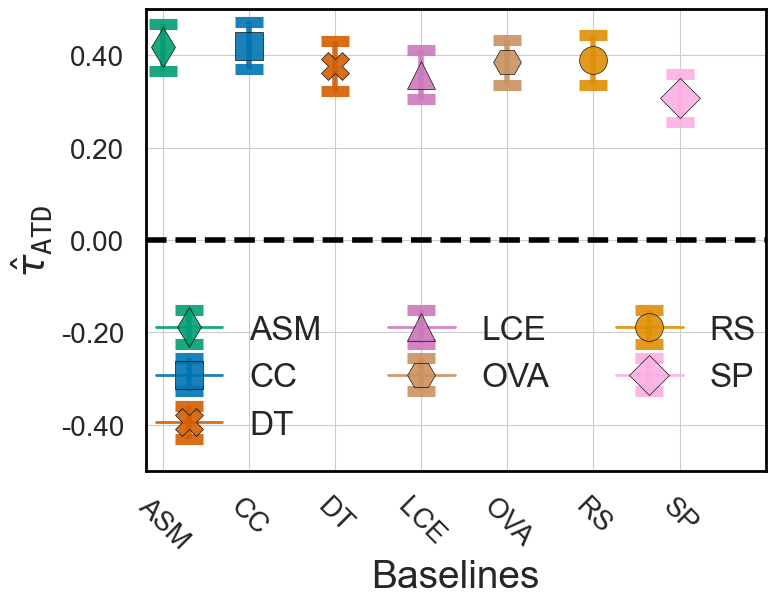

In [21]:
plots_all_classifiers_fixed_cov(df[df["data"]=="synth"], .9, figsize=(8,6), img_title="synth".format("ATT"), metric="ATT")

## appendix Plot

In [22]:
dict_best = {
    "synth": "ASM",
    "hatespeech": "RS",
    "cifar10h": "CC",
    "galaxyzoo": "CC",
    "xray-airspace": "RS"
}

dict_cols = {
    "synth": 0,
    "hatespeech": 3,
    "cifar10h": 1,
    "galaxyzoo": 2,
    "xray-airspace": 4
}


def plot_all_best_checks_placebo(ylim=None):
    filename_orig = "../results/all_results.csv"
    filename_pl = "../results/all_resultsPLACEBO.csv"
    filename_pl_low = "../results/all_resultsPLACEBOCUTOFFS_LOW.csv"
    filename_pl_high = "../results/all_resultsPLACEBOCUTOFFS_HIGH.csv"
    db_orig = pd.read_csv(filename_orig).fillna(0)
    db_pl = pd.read_csv(filename_pl).fillna(0)
    db_pl_low = pd.read_csv(filename_pl_low).fillna(0)
    db_pl_high = pd.read_csv(filename_pl_high).fillna(0)
    fig, ax = plt.subplots(4,5, figsize=(28, 28), sharey=True, sharex=True)
    fig.tight_layout() #
    target_coverages = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
    db_orig = db_orig[db_orig["target_coverage"].isin(target_coverages)]
    db_pl = db_pl[db_pl["target_coverage"].isin(target_coverages)]
    db_pl_low = db_pl_low[db_pl_low["target_coverage"].isin(target_coverages)]
    db_pl_high = db_pl_high[db_pl_high["target_coverage"].isin(target_coverages)]
    for data in ["synth", "hatespeech", "cifar10h", "galaxyzoo", "xray-airspace"]:
        tmp = db_orig[(db_orig["data"]==data) & (db_orig["method"] == dict_best[data])].copy()
        tmp_pl = db_pl[(db_pl["data"]==data) & (db_pl["method"] == dict_best[data])].copy()
        tmp_pl_low = db_pl_low[(db_pl_low["data"]==data) & (db_pl_low["method"] == dict_best[data])].copy()
        tmp_pl_high = db_pl_high[(db_pl_high["data"]==data) & (db_pl_high["method"] == dict_best[data])].copy()
        (_, caps, _) = ax[0, dict_cols[data]].errorbar(tmp["target_coverage"], tmp["coef_rob"], label=dict_best[data], color=palette[dict_best[data]],yerr=(tmp["ci_rob_u"]-tmp["ci_rob_l"])/2, alpha=0.9, capsize=10,
                        elinewidth=4, marker=markers_dict[dict_best[data]], markersize=20, markeredgecolor = 'black',markeredgewidth = 0.5)
        for cap in caps:
                cap.set_markeredgewidth(8)
        if (ylim is not None) & (dict_cols[data] == 0):
            ax[0, dict_cols[data]].set_ylim(ylim)
        ax[0, dict_cols[data]].hlines(y=0, linestyles='dashed', colors='black', xmin=0, xmax=1, linewidth=4, label="Null Effect")
        ax[0, dict_cols[data]].set_title(data, fontsize=36)
        ax[0, dict_cols[data]].set_xlabel("")
        #second row -- placebo low
        (_, caps, _) = ax[1, dict_cols[data]].errorbar(tmp_pl_low["target_coverage"], tmp_pl_low["coef_rob"], label=dict_best[data], color=palette[dict_best[data]],yerr=(tmp_pl_low["ci_rob_u"]-tmp_pl_low["ci_rob_l"])/2, alpha=0.9, capsize=10,
                        elinewidth=4, marker=markers_dict[dict_best[data]], markersize=20, markeredgecolor = 'black',markeredgewidth = 0.5)
        for cap in caps:
                cap.set_markeredgewidth(8)
        ax[1, dict_cols[data]].hlines(y=0, linestyles='dashed', colors='black', xmin=0, xmax=1, linewidth=4, label="Null Effect")
        if (ylim is not None) & (dict_cols[data] == 0):
            ax[1, dict_cols[data]].set_ylim(ylim)
        #third row -- placebo high
        (_, caps, _) = ax[2, dict_cols[data]].errorbar(tmp_pl_high["target_coverage"], tmp_pl_high["coef_rob"], label=dict_best[data], color=palette[dict_best[data]],yerr=(tmp_pl_high["ci_rob_u"]-tmp_pl_high["ci_rob_l"])/2, alpha=0.9, capsize=10,
                        elinewidth=4, marker=markers_dict[dict_best[data]], markersize=20, markeredgecolor = 'black',markeredgewidth = 0.5)
        for cap in caps:
                cap.set_markeredgewidth(8)
        ax[2, dict_cols[data]].hlines(y=0, linestyles='dashed', colors='black', xmin=0, xmax=1, linewidth=4, label="Null Effect")
        if (ylim is not None) & (dict_cols[data] == 0):
            ax[2, dict_cols[data]].set_ylim(ylim)
        #fourth row -- placebo outcome
        (_, caps, _) = ax[3, dict_cols[data]].errorbar(tmp_pl["target_coverage"], tmp_pl["coef_rob"], label=dict_best[data], color=palette[dict_best[data]],yerr=(tmp_pl["ci_rob_u"]-tmp_pl["ci_rob_l"])/2, alpha=0.9, capsize=10,
                        elinewidth=4, marker=markers_dict[dict_best[data]], markersize=20, markeredgecolor = 'black',markeredgewidth = 0.5)
        for cap in caps:
                cap.set_markeredgewidth(8)
        ax[3, dict_cols[data]].hlines(y=0, linestyles='dashed', colors='black', xmin=0, xmax=1, linewidth=4, label="Null Effect")
        if (ylim is not None) & (dict_cols[data] == 0):
            ax[3, dict_cols[data]].set_ylim(ylim)
    fig.text(0.5, -0.01, "Cutoff", ha='center', fontsize=36)
    # fig.text(-0.01, 0.5, "$\\tau_{\mathtt{RD}}$", va='center', rotation='vertical', fontsize=36)
    ax[3,dict_cols[data]].set_xticks(target_coverages)
    xticks = ["$"+"{:.2f}".format(x).replace("0.",".")+"$" for x in target_coverages]
    xticks = [el if i%2 ==0 else "" for i,el in enumerate(xticks)]
    ax[3, 0].set_xticklabels(xticks, fontsize=28)
    ax[3, 1].set_xticklabels(xticks, fontsize=28)
    ax[3, 2].set_xticklabels(xticks, fontsize=28)
    ax[3, 3].set_xticklabels(xticks, fontsize=28)
    ax[3, 4].set_xticklabels(xticks, fontsize=28)
    ax[0, 0].legend(loc="upper center", fontsize=32, markerscale=1, fancybox=True, shadow=False)
    ax[0, 1].legend(loc="lower center", fontsize=32, markerscale=1, fancybox=True, shadow=False)
    ax[0, 2].legend(loc="lower center", fontsize=32, markerscale=1, fancybox=True, shadow=False)
    ax[0, 3].legend(loc="lower center", fontsize=32, markerscale=1, fancybox=True, shadow=False)
    ax[0, 4].legend(loc="upper center", fontsize=32, markerscale=1, fancybox=True, shadow=False)
    ax[0,0].set_ylabel("$\hat{\\tau}_{\mathtt{RD}}$", fontsize=32)
    ax[1,0].set_ylabel("$\hat{\\tau}_{\mathtt{RD}}-$"+" cutoff lower", fontsize=32)
    ax[2,0].set_ylabel("$\hat{\\tau}_{\mathtt{RD}}-$"+ "cutoff higher", fontsize=32)
    ax[3,0].set_ylabel("$\hat{\\tau}_{\mathtt{RD}}-$"+" placebo outcome", fontsize=32)
    # ax[0,0].set_ylabel("$\\tau_{\mathtt{RD}}$", fontsize=36)
    # ax[1,0].set_ylabel("Robustness Coefficient", fontsize=36)
    # ax[2,0].set_ylabel("Robustness Coefficient", fontsize=36)
    # ax[3,0].set_ylabel("Robustness Coefficient", fontsize=36)
    plt.savefig("{}/all_best_checks_placebo.png".format(img_fold), bbox_inches='tight', dpi=300)
    plt.show()



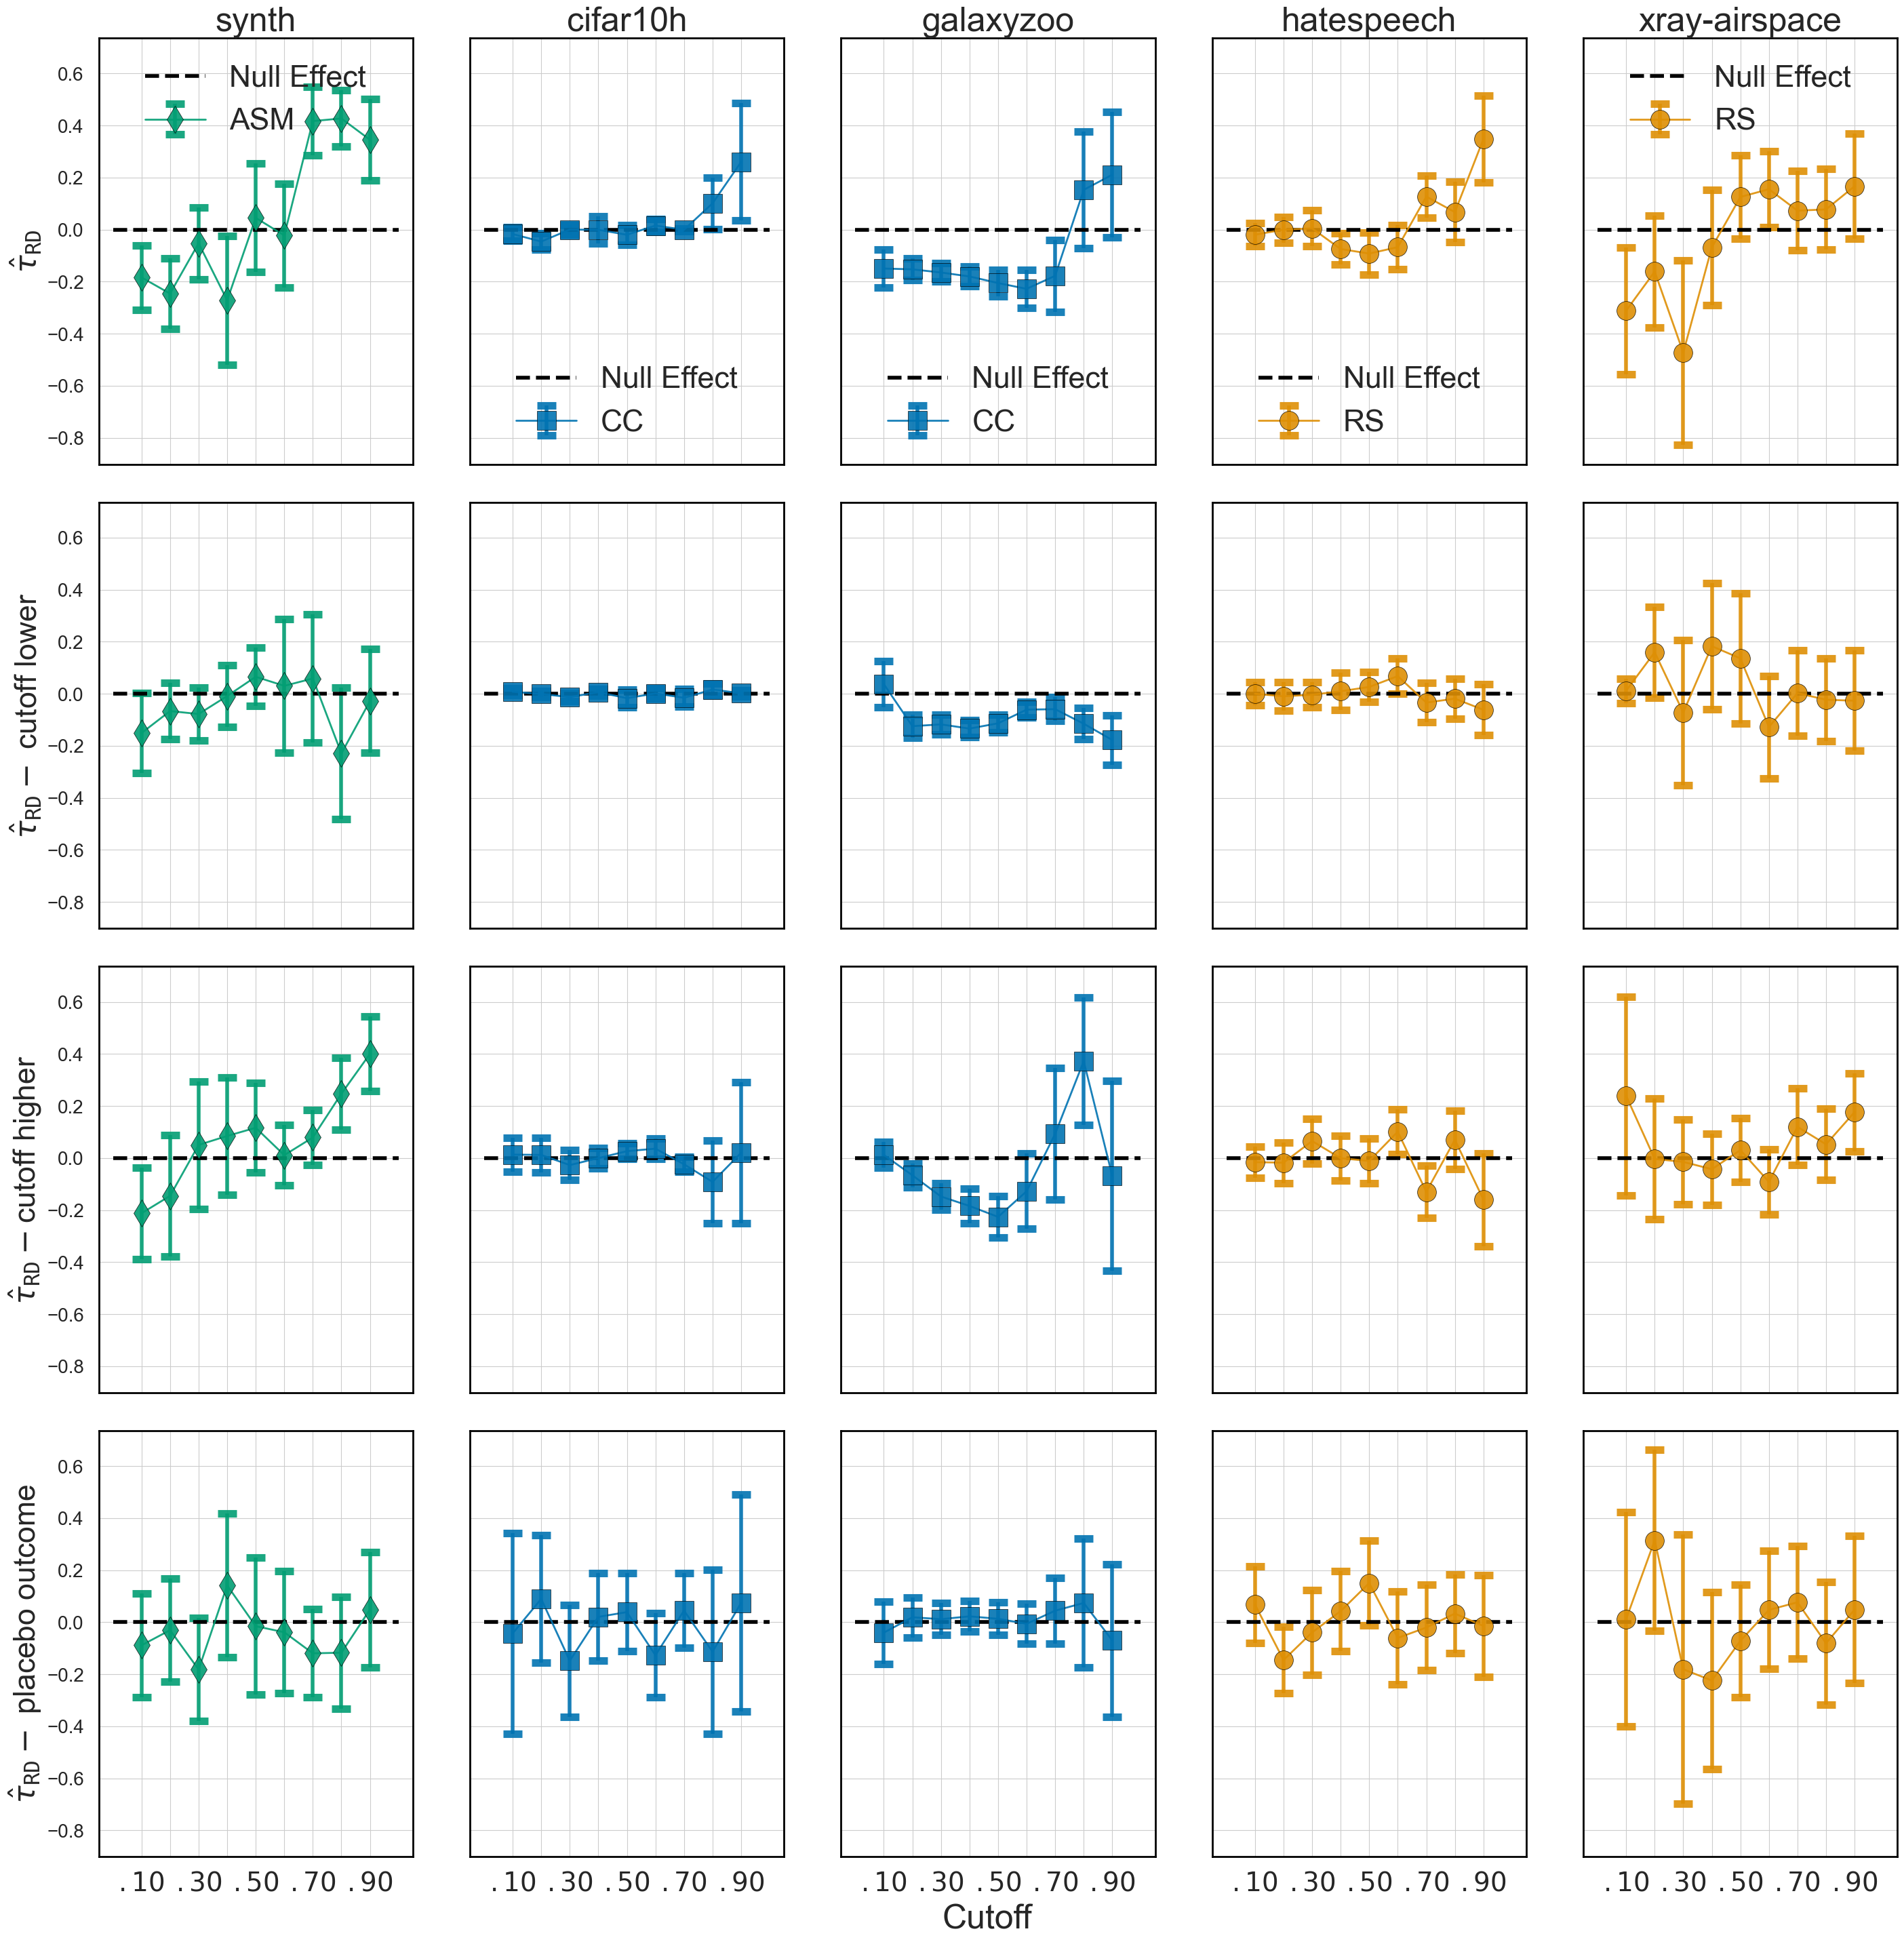

In [23]:
plot_all_best_checks_placebo()